# Brain tumor Classification on MRI images 

### Dataset used : 
#### Navoneel Chakrabarty & Swati Kanchan
<i> https://www.kaggle.com/sartajbhuvaji/brain-tumor-classification-mri </i> <br>
API : kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri

In [1]:
import os
import cv2
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dropout, Activation, Flatten
import tensorflow.keras.regularizers as regul
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
from helper import fetch_resize_save
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
#Resizing 
RERUN = False 
train_path = 'data/Training/'
test_path = 'data/Testing/'
if RERUN : 
    # resizing and save resized images. 
    # train data
    fetch_resize_save(pick_path = train_path, save_folder = 'data/Resized', resize_size = (240,240), sample_type = 'train')
    # test data
    fetch_resize_save(pick_path = test_path, save_folder = 'data/Resized', resize_size = (240,240), sample_type = 'test')

In [2]:
#Building training set 
path = 'data/Resized/train'
filenames = []
images = []
for filename in os.listdir(path):
    filenames.append(filename)
    image = np.array(cv2.imread(os.path.join(path, filename)))
    images.append(image)
train_images = np.array(images)
X_train = train_images/255
print(f'total number of images loaded : {len(train_images)}')
print(f'shape of image array : {train_images.shape}')
y_train = pd.Series([x[0] for x in filenames]).map({'n':0, 'g': 1, 'm': 2, 'p': 3})

total number of images loaded : 2870
shape of image array : (2870, 240, 240, 3)


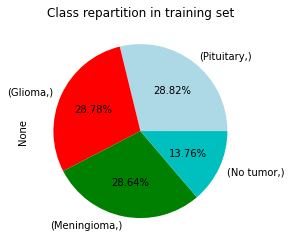

In [3]:
y_pie_train = pd.DataFrame(y_train).rename({0:'class'}, axis = 1).value_counts().rename({0:'No tumor', 1:'Glioma', 2:'Meningioma', 3:'Pituitary'}).plot.pie(autopct = "%.2f%%",colors = ['lightblue', 'r', 'g', 'c'], title ='Class repartition in training set')

total number of images loaded : 394
shape of image array : (394, 240, 240, 3)


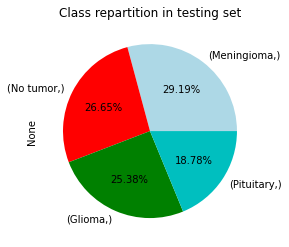

In [4]:
# Building validation set 
path = 'data/Resized/test'
filenames = []
images = []
for filename in os.listdir(path):
    filenames.append(filename)
    image = np.array(cv2.imread(os.path.join(path, filename)))
    images.append(image)
test_images = np.array(images)
print(f'total number of images loaded : {len(test_images)}')
print(f'shape of image array : {test_images.shape}')

y_test = pd.Series([x[0] for x in filenames]).map({'n':0, 'g': 1, 'm': 2, 'p': 3})
y_test_train = pd.DataFrame(y_test).rename({0:'class'}, axis = 1).value_counts().rename({0:'No tumor', 1:'Glioma', 2:'Meningioma', 3:'Pituitary'}).plot.pie(autopct = "%.2f%%",colors = ['lightblue', 'r', 'g', 'c'], title ='Class repartition in testing set')

y_test = pd.get_dummies(y_test)
X_test = test_images/255

In [5]:
# stratify split is needed because of low amount of no-tumor image
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X_train, y_train, test_size = 0.2, stratify = y_train)

In [6]:
# one hot encoding for Y values
# y_train
y_train_dummy = np.zeros(shape = (ytrain.shape[0], 4))
for i, elem in enumerate(ytrain):
    y_train_dummy[i][elem] = 1
# y_valid
y_valid_dummy = np.zeros(shape = (yvalid.shape[0], 4))
for i, elem in enumerate(yvalid):
    y_valid_dummy[i][elem] = 1
    
ytrain, yvalid = y_train_dummy, y_valid_dummy

In [7]:
# removing some variables to save RAM.
del X_train
del y_train

# Training personals models.

### Simpliest CNN

In [13]:
model_base = Sequential()

model_base.add(Conv2D(16, (5,5), padding = 'same', input_shape = Xtrain.shape[1:]))
model_base.add(Activation('relu'))
model_base.add(MaxPooling2D(pool_size = (2,2)))
model_base.add(Flatten())
model_base.add(Dense(128))
model_base.add(Activation('relu'))
model_base.add(Dense(4))
model_base.add(Activation('softmax'))

batch_size = 8
opt = keras.optimizers.Adam(learning_rate=0.001)

model_base.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_base.fit(Xtrain, ytrain,
              batch_size=batch_size,
              epochs=10,
              validation_data=(Xvalid, yvalid),
              shuffle=True)

Epoch 1/10
287/287 [==============================] - 15s 49ms/step - loss: 2.9805 - accuracy: 0.5577 - val_loss: 0.4723 - val_accuracy: 0.8118
Epoch 2/10
287/287 [==============================] - 13s 47ms/step - loss: 0.2271 - accuracy: 0.9178 - val_loss: 0.3143 - val_accuracy: 0.8920
Epoch 3/10
287/287 [==============================] - 12s 42ms/step - loss: 0.0585 - accuracy: 0.9819 - val_loss: 0.4108 - val_accuracy: 0.8815
Epoch 4/10
287/287 [==============================] - 12s 40ms/step - loss: 0.0119 - accuracy: 0.9978 - val_loss: 0.4796 - val_accuracy: 0.8746
Epoch 5/10
287/287 [==============================] - 12s 41ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.9508 - val_accuracy: 0.7613
Epoch 6/10
287/287 [==============================] - 12s 40ms/step - loss: 0.0331 - accuracy: 0.9847 - val_loss: 0.4599 - val_accuracy: 0.8955
Epoch 7/10
287/287 [==============================] - 12s 41ms/step - loss: 0.0245 - accuracy: 0.9901 - val_loss: 0.6146 - val_accuracy:

0.8787456512451172


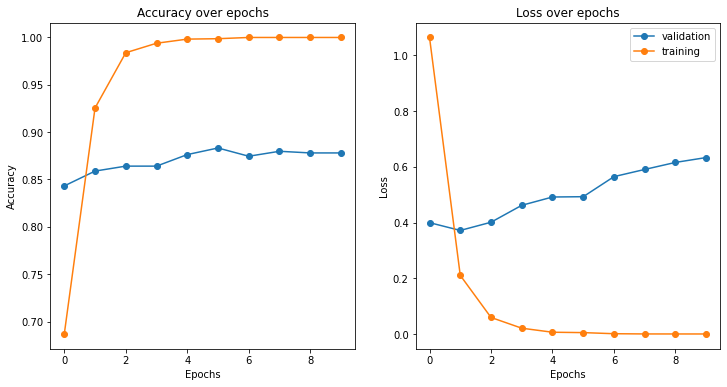

In [21]:
history = model_base.history.history
fig, axs = plt.subplots(1, 2,figsize = (12,6))

axs[0].plot(history.get('val_accuracy'), label = 'validation', marker = 'o')
axs[0].plot(history.get('accuracy'), label = 'training', marker = 'o')
axs[0].set_title('Accuracy over epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history.get('val_loss'), label = 'validation', marker = 'o')
axs[1].plot(history.get('loss'), label = 'training', marker = 'o')
axs[1].set_title('Loss over epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')

plt.legend()
mean_lasts = np.mean(history.get('val_accuracy')[-5:])
print(mean_lasts)

Very poor generalization.

In [22]:
model_base.evaluate(X_test, y_test)

13/13 [==============================] - 1s 39ms/step - loss: 5.4714 - accuracy: 0.7284


[5.471404552459717, 0.7284263968467712]

### Second model, still basic.

In [9]:
model1 = Sequential()
model1.add(Conv2D(16, (5, 5), padding = 'same', input_shape = Xtrain.shape[1:]))
model1.add(Activation('relu'))

model1.add(Conv2D(16, (3,3), padding = 'same'))
model1.add(Activation('relu'))

model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.3))

model1.add(Flatten())
model1.add(Dense(256))
model1.add(Activation('relu'))

model1.add(Dense(16))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))

model1.add(Dense(4))
model1.add(Activation('softmax'))


In [10]:
batch_size = 16
opt = keras.optimizers.Adam(learning_rate=0.001)

model1.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model1.fit(Xtrain, ytrain,
              batch_size=batch_size,
              epochs=30,
              validation_data=(Xvalid, yvalid),
              shuffle=True)

Epoch 1/30
144/144 [==============================] - 45s 105ms/step - loss: 1.5810 - accuracy: 0.3849 - val_loss: 0.9676 - val_accuracy: 0.5488
Epoch 2/30
144/144 [==============================] - 14s 98ms/step - loss: 0.9672 - accuracy: 0.5279 - val_loss: 0.7457 - val_accuracy: 0.6864
Epoch 3/30
144/144 [==============================] - 14s 100ms/step - loss: 0.7727 - accuracy: 0.6226 - val_loss: 0.5859 - val_accuracy: 0.7125
Epoch 4/30
144/144 [==============================] - 14s 100ms/step - loss: 0.6274 - accuracy: 0.7132 - val_loss: 0.4621 - val_accuracy: 0.8118
Epoch 5/30
144/144 [==============================] - 14s 97ms/step - loss: 0.5492 - accuracy: 0.7325 - val_loss: 0.4723 - val_accuracy: 0.8275
Epoch 6/30
144/144 [==============================] - 14s 97ms/step - loss: 0.4697 - accuracy: 0.7687 - val_loss: 0.4567 - val_accuracy: 0.8502
Epoch 7/30
144/144 [==============================] - 14s 100ms/step - loss: 0.3738 - accuracy: 0.8436 - val_loss: 0.4999 - val_accur

0.8682926774024964


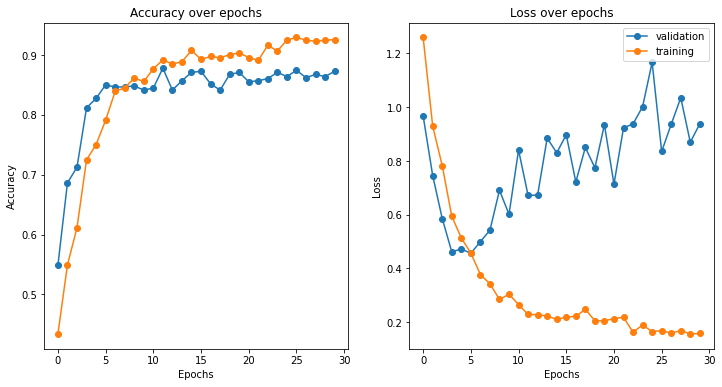

In [11]:
history = model1.history.history
fig, axs = plt.subplots(1, 2,figsize = (12,6))

axs[0].plot(history.get('val_accuracy'), label = 'validation', marker = 'o')
axs[0].plot(history.get('accuracy'), label = 'training', marker = 'o')
axs[0].set_title('Accuracy over epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history.get('val_loss'), label = 'validation', marker = 'o')
axs[1].plot(history.get('loss'), label = 'training', marker = 'o')
axs[1].set_title('Loss over epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')

plt.legend()
mean_lasts = np.mean(history.get('val_accuracy')[-5:])
print(mean_lasts)

In [12]:
model1.evaluate(X_test, y_test)

13/13 [==============================] - 1s 56ms/step - loss: 5.0765 - accuracy: 0.6777


[5.076456069946289, 0.6776649951934814]

- Dropout explain  higher validation accuracy
- Model simplicity explains the not sky-high accuracy (88%).

###  Second CNN, more complex.

The model have really high training accuracy but not that great testing accuracy : it overfits.
generalization needs to be improved. 

In [12]:
model3 = Sequential()

model3.add(Conv2D(32, (5,5), padding = 'same', input_shape = Xtrain.shape[1:], activation = 'relu'))
model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Dropout(0.25))

model3.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model3.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))

model3.add(MaxPooling2D(pool_size = (2, 2)))
model3.add(Flatten())
model3.add(Dense(128, activation ='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(4, activation = 'softmax'))

#model3.summary()

In [13]:
opt = keras.optimizers.Adam(learning_rate = 0.001)
model3.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])
model3.fit(Xtrain, ytrain,
          shuffle = True,
          batch_size = 8,
          epochs = 15,
          validation_data = (Xvalid, yvalid))

Epoch 1/15
287/287 [==============================] - 15s 47ms/step - loss: 1.2552 - accuracy: 0.4638 - val_loss: 0.7688 - val_accuracy: 0.6516
Epoch 2/15
287/287 [==============================] - 13s 45ms/step - loss: 0.7031 - accuracy: 0.6980 - val_loss: 0.6192 - val_accuracy: 0.7509
Epoch 3/15
287/287 [==============================] - 12s 43ms/step - loss: 0.4742 - accuracy: 0.8122 - val_loss: 0.6076 - val_accuracy: 0.7648
Epoch 4/15
287/287 [==============================] - 12s 43ms/step - loss: 0.2715 - accuracy: 0.8995 - val_loss: 0.4846 - val_accuracy: 0.8171
Epoch 5/15
287/287 [==============================] - 15s 53ms/step - loss: 0.1504 - accuracy: 0.9458 - val_loss: 0.4031 - val_accuracy: 0.8571
Epoch 6/15
287/287 [==============================] - 13s 45ms/step - loss: 0.0963 - accuracy: 0.9575 - val_loss: 0.5703 - val_accuracy: 0.8362
Epoch 7/15
287/287 [==============================] - 13s 44ms/step - loss: 0.1006 - accuracy: 0.9703 - val_loss: 0.4521 - val_accuracy:

0.8679442405700684


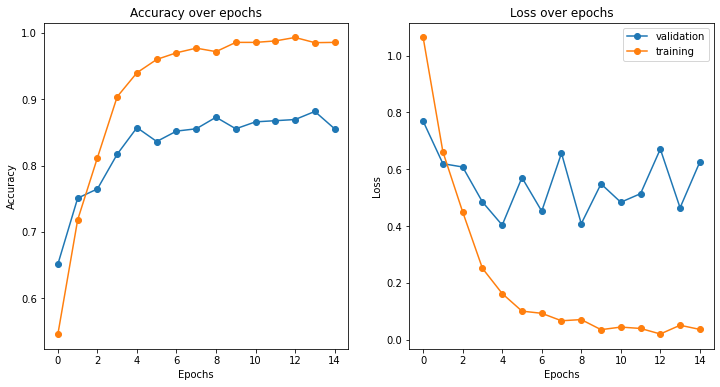

In [14]:
history = model3.history.history
fig, axs = plt.subplots(1, 2,figsize = (12,6))

axs[0].plot(history.get('val_accuracy'), label = 'validation', marker = 'o')
axs[0].plot(history.get('accuracy'), label = 'training', marker = 'o')
axs[0].set_title('Accuracy over epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history.get('val_loss'), label = 'validation', marker = 'o')
axs[1].plot(history.get('loss'), label = 'training', marker = 'o')
axs[1].set_title('Loss over epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')

plt.legend()
mean_lasts = np.mean(history.get('val_accuracy')[-5:])
print(mean_lasts)

- Gained roughly 2% accuracy.

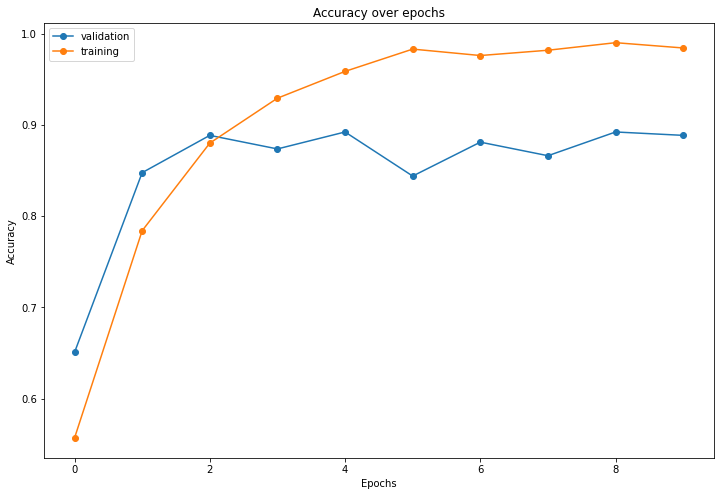

In [28]:
accuracy = history.get('accuracy') + model3.history.history.get('accuracy')
val_accuracy = history.get('val_accuracy') + model3.history.history.get('val_accuracy')

plt.figure(figsize = (12,8))
plt.plot(val_accuracy, label = 'validation', marker = 'o')
plt.plot(accuracy, label = 'training', marker = 'o')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

### Add regularization

In [25]:
model4 = Sequential()

model4.add(Conv2D(32, (5,5), padding='same', input_shape=Xtrain.shape[1:],
                  activation='relu'))
model4.add(MaxPooling2D(pool_size = (2, 2)))

model4.add(Dropout(0.25))

model4.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu'))
model4.add(Conv2D(16, (3,3), padding = 'same', activation = 'relu'))

model4.add(MaxPooling2D(pool_size = (2, 2)))
model4.add(Flatten())

model4.add(Dense(200, activation ='relu', kernel_regularizer = regul.L2(l2=0.001)))
model4.add(Dropout(0.4))

model4.add(Dense(64, activation = 'relu'))
model4.add(Dense(16, activation = 'relu'))

model4.add(Dense(4, activation = 'softmax'))


In [26]:
opt = keras.optimizers.Adam(learning_rate = 0.002, decay = 1e-6)
model4.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])
model4.fit(Xtrain, ytrain,
          shuffle = True,
          batch_size = 8,
          epochs = 50,
          validation_data = (Xvalid, yvalid))

Epoch 1/50
269/269 [==============================] - 13s 45ms/step - loss: 1.3187 - accuracy: 0.4107 - val_loss: 0.8310 - val_accuracy: 0.5978
Epoch 2/50
269/269 [==============================] - 11s 42ms/step - loss: 0.8384 - accuracy: 0.6306 - val_loss: 0.6636 - val_accuracy: 0.7263
Epoch 3/50
269/269 [==============================] - 11s 42ms/step - loss: 0.6017 - accuracy: 0.7393 - val_loss: 0.5366 - val_accuracy: 0.7672
Epoch 4/50
269/269 [==============================] - 11s 42ms/step - loss: 0.3831 - accuracy: 0.8546 - val_loss: 0.4325 - val_accuracy: 0.8305
Epoch 5/50
269/269 [==============================] - 11s 42ms/step - loss: 0.2674 - accuracy: 0.8921 - val_loss: 0.3771 - val_accuracy: 0.8268
Epoch 6/50
269/269 [==============================] - 11s 42ms/step - loss: 0.1391 - accuracy: 0.9508 - val_loss: 0.3833 - val_accuracy: 0.8473
Epoch 7/50
269/269 [==============================] - 11s 42ms/step - loss: 0.1349 - accuracy: 0.9573 - val_loss: 0.4228 - val_accuracy:

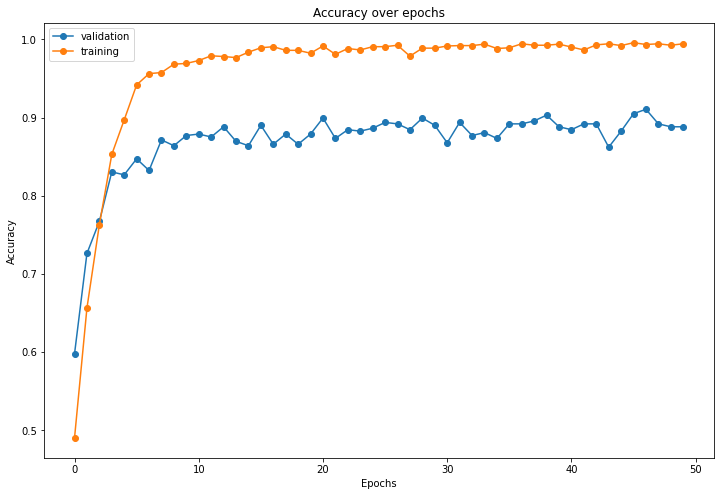

In [27]:
history = model4.history.history
fig = plt.figure(figsize = (12,8))
plt.plot(history.get('val_accuracy'), label = 'validation', marker = 'o')
plt.plot(history.get('accuracy'), label = 'training', marker = 'o')
plt.title('Accuracy over epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

In [18]:
model4.evaluate(X_test, y_test)

NameError: name 'model4' is not defined

## Final Model

In [14]:
del model5

In [17]:
feature_layers = [
    Conv2D(64, (5,5), padding='same', input_shape=Xtrain.shape[1:],
                  strides = 2,activation='relu', kernel_regularizer = regul.l1(l1 = 0.00001)),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.1),
    Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
    Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
    Dropout(0.2),
    Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
    Conv2D(128, (3,3), padding = 'same', activation = 'relu'),

    MaxPooling2D(pool_size = (2, 2)),
]

classification_layers = [
    Flatten(),
    Dense(256, activation ='relu'),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(4, activation = 'softmax'),
]

model5 = Sequential(feature_layers + classification_layers)

In [18]:
opt = keras.optimizers.Adam(learning_rate = 0.001)
model5.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model5.fit(Xtrain, ytrain,
          shuffle = True,
          batch_size = 8,
          epochs = 30,
          validation_data = (Xvalid, yvalid))

Epoch 1/30
287/287 [==============================] - 14s 44ms/step - loss: 1.3517 - accuracy: 0.2959 - val_loss: 1.0668 - val_accuracy: 0.5139
Epoch 2/30
287/287 [==============================] - 12s 42ms/step - loss: 1.0904 - accuracy: 0.4871 - val_loss: 0.7911 - val_accuracy: 0.6551
Epoch 3/30
287/287 [==============================] - 12s 42ms/step - loss: 0.7778 - accuracy: 0.6535 - val_loss: 0.6215 - val_accuracy: 0.7578
Epoch 4/30
287/287 [==============================] - 12s 41ms/step - loss: 0.6356 - accuracy: 0.7200 - val_loss: 0.5388 - val_accuracy: 0.8014
Epoch 5/30
287/287 [==============================] - 12s 42ms/step - loss: 0.5429 - accuracy: 0.7780 - val_loss: 0.5492 - val_accuracy: 0.7282
Epoch 6/30
287/287 [==============================] - 12s 42ms/step - loss: 0.4848 - accuracy: 0.7855 - val_loss: 0.5381 - val_accuracy: 0.7561
Epoch 7/30
287/287 [==============================] - 12s 42ms/step - loss: 0.4126 - accuracy: 0.8382 - val_loss: 0.3686 - val_accuracy:

0.9114982604980468


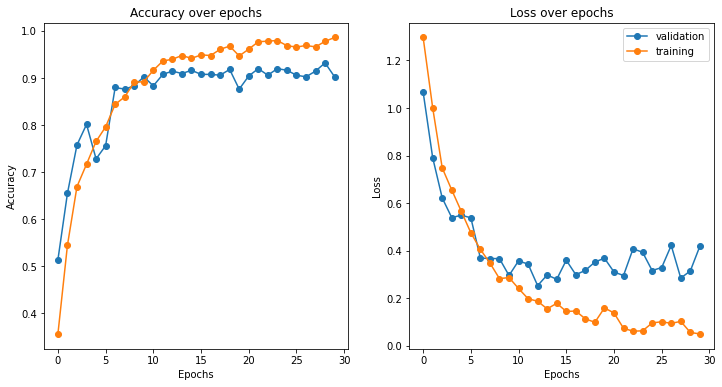

In [19]:
history = model5.history.history
fig, axs = plt.subplots(1, 2,figsize = (12,6))

axs[0].plot(history.get('val_accuracy'), label = 'validation', marker = 'o')
axs[0].plot(history.get('accuracy'), label = 'training', marker = 'o')
axs[0].set_title('Accuracy over epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history.get('val_loss'), label = 'validation', marker = 'o')
axs[1].plot(history.get('loss'), label = 'training', marker = 'o')
axs[1].set_title('Loss over epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')

plt.legend()
mean_lasts = np.mean(history.get('val_accuracy')[-5:])
print(mean_lasts)

In [20]:
model5.evaluate(X_test, y_test)

13/13 [==============================] - 1s 54ms/step - loss: 3.9048 - accuracy: 0.7005


[3.904838800430298, 0.700507640838623]

# Transfert Learning 

## Using trained CNN to detect tumors on other MRI datasets

Using the lasts CNN that have been trained, we'll try to use it in order to detect wether a brain MRI image presents a tumor or not, on a way smaller dataset.

In [8]:
# First : resize secondary dataset to the same size the network has been trained on : 240 x 240.

In [13]:
#Resizing images
RERUN = True
fetch_path = 'data/second/'
if RERUN : 
    fetch_resize_save(pick_path = fetch_path, save_folder = 'data/Resized/second', resize_size = (240,240), sample_type = 'train')


total number of images loaded : 253


In [21]:
path = 'data/Resized/second/train'
filenames = []
images = []
for filename in os.listdir(path):
    filenames.append(filename)
    image = np.array(cv2.imread(os.path.join(path, filename)))
    images.append(image)
train_images = np.array(images)
X_train2 = train_images/255
print(f'total number of images loaded : {len(train_images)}')
print(f'shape of image array : {train_images.shape}')

total number of images loaded : 253
shape of image array : (253, 240, 240, 3)


In [22]:
y_train2 = pd.Series([x[0] for x in filenames]).map({'n':0, 'y': 1})
y_train2.tail()

248    1
249    1
250    1
251    1
252    1
dtype: int64

In [23]:
Xtrain2, Xvalid2, ytrain2, yvalid2 = train_test_split(X_train2, y_train2, test_size = 0.2, stratify = y_train2)
ytrain2 = keras.utils.to_categorical(ytrain2, 2)
yvalid2 = keras.utils.to_categorical(yvalid2, 2)

In [ ]:
del X_train2
del y_train2

In [24]:
# Freeze the feature layers
for l in feature_layers:
    l.trainable = False
# Change the output of classifier
classification_layers[-1] = Dense(2, activation = 'softmax')

In [25]:
model_second = Sequential(feature_layers + classification_layers)

model_second.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model_second.fit(Xtrain2, ytrain2,
          shuffle = True,
          batch_size = 8,
          epochs = 10,
          validation_data = (Xvalid2, yvalid2))

Epoch 1/10
26/26 [==============================] - 3s 50ms/step - loss: 0.9518 - accuracy: 0.6802 - val_loss: 0.3246 - val_accuracy: 0.8431
Epoch 2/10
26/26 [==============================] - 1s 25ms/step - loss: 0.3618 - accuracy: 0.8586 - val_loss: 0.4100 - val_accuracy: 0.8235
Epoch 3/10
26/26 [==============================] - 1s 26ms/step - loss: 0.3126 - accuracy: 0.8859 - val_loss: 0.3989 - val_accuracy: 0.8627
Epoch 4/10
26/26 [==============================] - 1s 27ms/step - loss: 0.1573 - accuracy: 0.9392 - val_loss: 0.3765 - val_accuracy: 0.8627
Epoch 5/10
26/26 [==============================] - 1s 25ms/step - loss: 0.1270 - accuracy: 0.9738 - val_loss: 0.4043 - val_accuracy: 0.8824
Epoch 6/10
26/26 [==============================] - 1s 28ms/step - loss: 0.1465 - accuracy: 0.9469 - val_loss: 0.4545 - val_accuracy: 0.8627
Epoch 7/10
26/26 [==============================] - 1s 27ms/step - loss: 0.0745 - accuracy: 0.9728 - val_loss: 0.4476 - val_accuracy: 0.8627
Epoch 8/10
26

0.8705882430076599


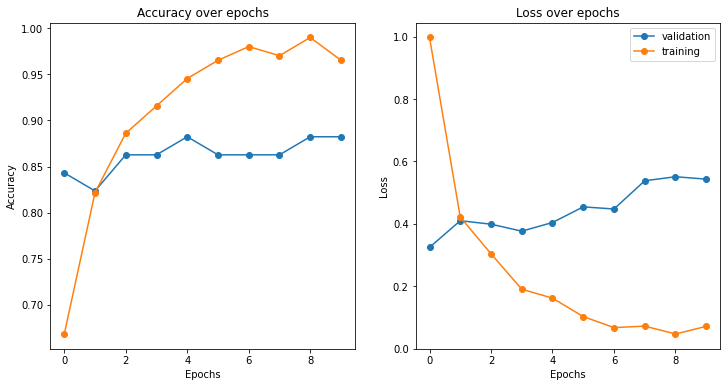

In [26]:
history = model_second.history.history
fig, axs = plt.subplots(1, 2,figsize = (12,6))

axs[0].plot(history.get('val_accuracy'), label = 'validation', marker = 'o')
axs[0].plot(history.get('accuracy'), label = 'training', marker = 'o')
axs[0].set_title('Accuracy over epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history.get('val_loss'), label = 'validation', marker = 'o')
axs[1].plot(history.get('loss'), label = 'training', marker = 'o')
axs[1].set_title('Loss over epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')

plt.legend()
mean_lasts = np.mean(history.get('val_accuracy')[-5:])
print(mean_lasts)

- Obtaining around 87% validation accuracy on tumor detection on the new dataset only by retraining the classifier, quite decent! 

## Transfert learning from Keras pretrained model.

In [8]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

In [14]:
model = ResNet50(include_top = False,
                weights = "imagenet",
                input_shape = (240, 240, 3))
# Freeze all the layers

for layer in model.layers[:]:
    layer.trainable = False



In [33]:
# add personnal classifier 
model_final = Sequential()
model_final.add(model)
model_final.add(Conv2D(32, (3,3), activation  = 'relu'))
model_final.add(MaxPooling2D(pool_size = (2,2)))
model_final.add(Flatten())
model_final.add(Dense(256, activation = 'relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(128, activation = 'relu'))
model_final.add(Dropout(0.2))
model_final.add(Dense(64, activation = 'relu'))
model_final.add(Dense(4, activation = 'softmax'))

In [35]:
model_final.compile(loss='categorical_crossentropy',
               optimizer= keras.optimizers.Adam(learning_rate = 0.001),
               metrics=['accuracy'])

model_final.fit(Xtrain, ytrain,
          shuffle = True,
          batch_size = 32,
          epochs = 40,
          validation_data = (Xvalid, yvalid))


Epoch 1/40
72/72 [==============================] - 30s 345ms/step - loss: 0.6218 - accuracy: 0.7453 - val_loss: 0.5435 - val_accuracy: 0.7805
Epoch 2/40
72/72 [==============================] - 23s 318ms/step - loss: 0.4421 - accuracy: 0.8213 - val_loss: 0.5438 - val_accuracy: 0.8084
Epoch 3/40
72/72 [==============================] - 23s 320ms/step - loss: 0.4134 - accuracy: 0.8359 - val_loss: 0.5509 - val_accuracy: 0.7770
Epoch 4/40
72/72 [==============================] - 23s 319ms/step - loss: 0.3990 - accuracy: 0.8372 - val_loss: 0.4674 - val_accuracy: 0.8118
Epoch 5/40
72/72 [==============================] - 23s 320ms/step - loss: 0.3846 - accuracy: 0.8462 - val_loss: 0.5826 - val_accuracy: 0.7875
Epoch 6/40
72/72 [==============================] - 23s 320ms/step - loss: 0.4158 - accuracy: 0.8222 - val_loss: 0.5031 - val_accuracy: 0.8188
Epoch 7/40
72/72 [==============================] - 23s 322ms/step - loss: 0.3772 - accuracy: 0.8510 - val_loss: 0.5264 - val_accuracy: 0.7997

In [30]:
model_final.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
module_wrapper_61 (ModuleWra (None, 4, 4, 2048)        0         
_________________________________________________________________
module_wrapper_62 (ModuleWra (None, 32768)             0         
_________________________________________________________________
module_wrapper_63 (ModuleWra (None, 256)               8388864   
_________________________________________________________________
module_wrapper_64 (ModuleWra (None, 256)               0         
_________________________________________________________________
module_wrapper_65 (ModuleWra (None, 128)               32896     
_________________________________________________________________
module_wrapper_66 (ModuleWra (None, 128)              

- Using ResNet50 architecture with ImageNet weight isn't efficient for tumor classification. 
- let's try to retrain the whole model now instead of only the classifier.
    - Not enough computing ressources.

## Image dimension increase using DBSCAN.

- Quick experimentation on combining DBSCAN clustering as a dimensionality increase and CNN for tumor classification 
- Work with 64 x 64 images this times, for my computer integrity sake

In [2]:
from sklearn.cluster import DBSCAN

In [3]:
# Loading & resizing images
path = 'data/Resized/train'
filenames = []
images = []
for filename in os.listdir(path):
    filenames.append(filename)
    image = np.array(cv2.imread(os.path.join(path, filename))) # Fetching images
    image = cv2.resize(image, (64,64), interpolation = cv2.INTER_CUBIC) #resizing to 64*64
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #grayscale
    images.append(image)
images = np.array(images)
images = images / 255
print(f'total number of images loaded : {len(images)}')

total number of images loaded : 2870


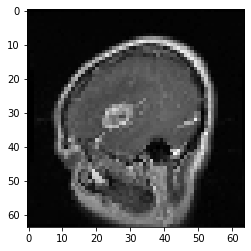

In [4]:
plt.imshow(images[3], 'gray')

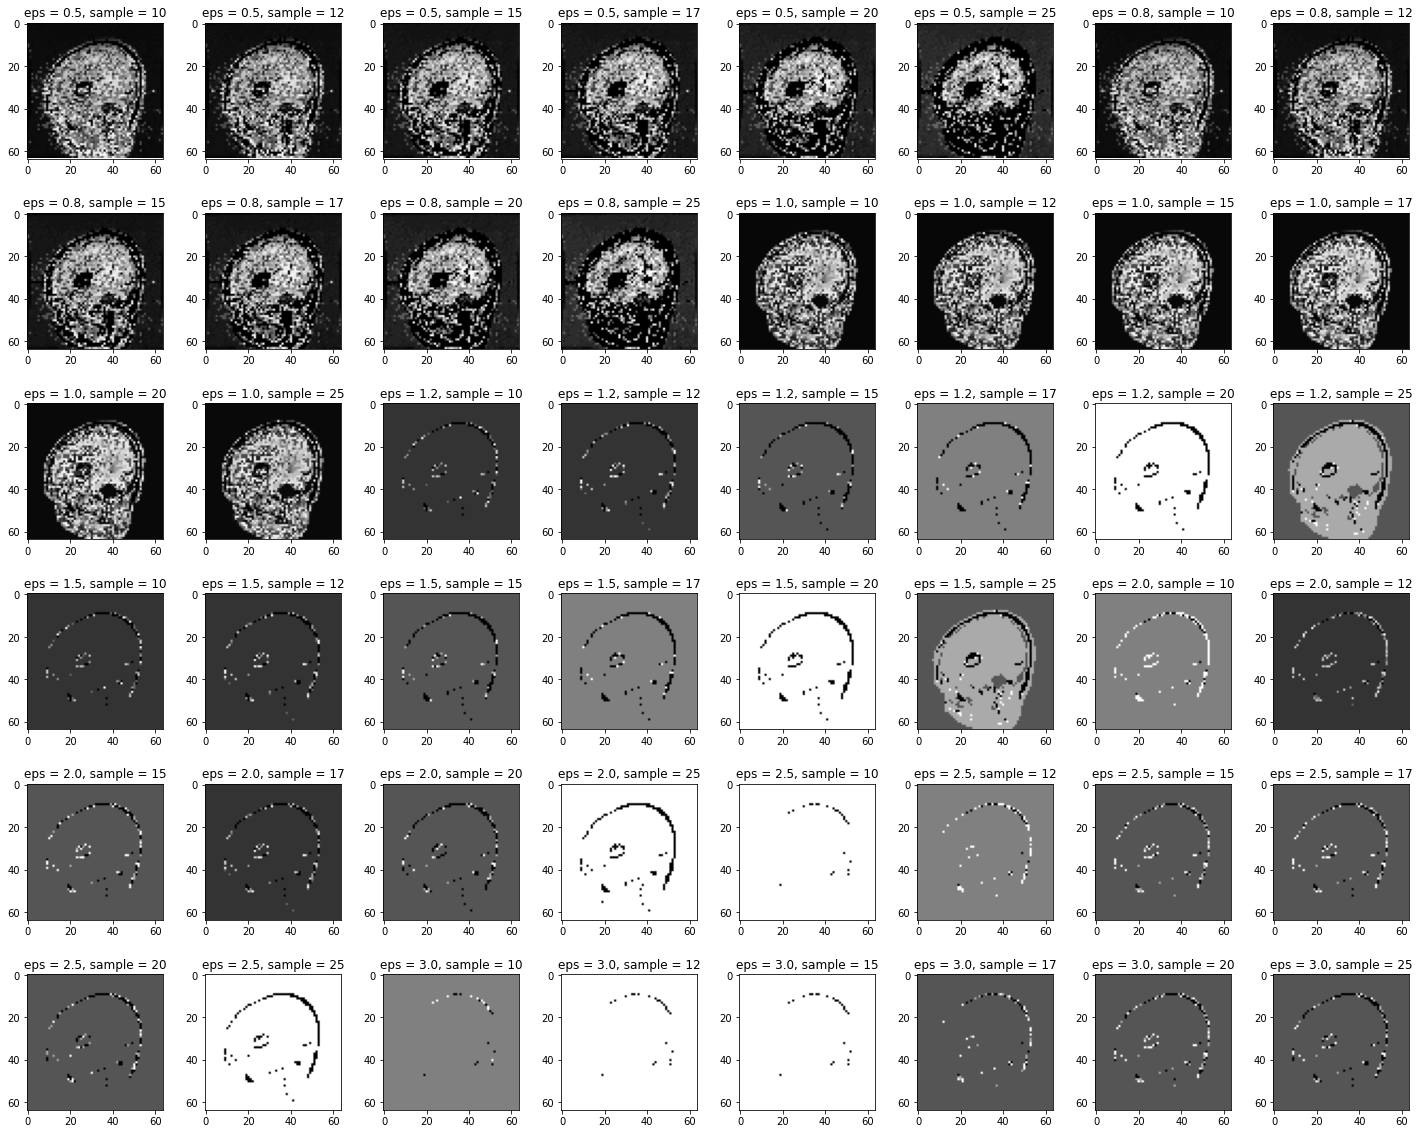

In [5]:
# parameters found in previous works.
eps = np.array([0.5, 0.8, 1, 1.2, 1.5, 2, 2.5, 3]) / 255 #adaptation to 0-255 -> 0-1 pixels magnitude.
min_samples = [10, 12, 15, 17, 20, 25]

fig, axs = plt.subplots(6, 8, figsize=(25,20))
axs = axs.ravel()
i = 0
#grid search iteration to select few sets of parameters.
for epsilon in eps:
    for sample in min_samples:
        dbs = DBSCAN(eps = epsilon, min_samples = sample)
        dbs.fit(images[3].reshape(-1,1))
        labels = dbs.labels_.reshape(64,64)
        axs[i].imshow(labels, 'gray')
        axs[i].set_title(f'eps = {epsilon*255}, sample = {sample}')
        i = i+1   
    
plt.subplots_adjust(hspace=0.4)
        

In [6]:
epsilons = np.array([0.8, 1.5, 2.0]) / 255
samples = [15, 25, 25]
images_dbs = np.empty( shape = (images.shape[0], images.shape[1], images.shape[2], 4), dtype = float)
images_dbs[:,:,:,0] = images
for index, img in enumerate(images):
    for dim, params in enumerate(zip(epsilons, samples)):
        dbs = DBSCAN(eps = params[0], min_samples = params[1])
        labels = dbs.fit(img.reshape(-1,1)).labels_.reshape(64,64)
        images_dbs[index, :, :, dim+1] = labels

In [7]:
y_train = pd.Series([x[0] for x in filenames]).map({'n':0, 'g': 1, 'm': 2, 'p': 3}).values 

In [8]:
# stratified splits. 
Xtrain, Xvalid, ytrain, yvalid = train_test_split(images_dbs, y_train, test_size = 0.2, stratify = y_train)
# one hot encoding for Y values
# y_train
y_train_dummy = np.zeros(shape = (ytrain.shape[0], 4))
for i, elem in enumerate(ytrain):
    y_train_dummy[i][elem] = 1
# y_valid
y_valid_dummy = np.zeros(shape = (yvalid.shape[0], 4))
for i, elem in enumerate(yvalid):
    y_valid_dummy[i][elem] = 1
    
ytrain, yvalid = y_train_dummy, y_valid_dummy

In [70]:
del model5


In [9]:
feature_layers = [
    Conv2D(64, (5,5), padding='same', input_shape=Xtrain.shape[1:],
                  strides = 2,activation='relu', kernel_regularizer = regul.l1(l1 = 0.00001)),
    MaxPooling2D(pool_size = (2, 2)),
    Dropout(0.1),
    Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    Conv2D(64, (3,3), padding = 'same', activation = 'relu'),
    
    MaxPooling2D(pool_size = (2, 2)),

    Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
    Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
    Dropout(0.2),
    Conv2D(128, (3,3), padding = 'same', activation = 'relu'),
    Conv2D(128, (3,3), padding = 'same', activation = 'relu'),

    MaxPooling2D(pool_size = (2, 2)),
]

classification_layers = [
    Flatten(),
    Dense(256, activation ='relu'),
    Dropout(0.4),
    Dense(128, activation = 'relu'),
    Dropout(0.3),
    Dense(4, activation = 'softmax'),
]

model5 = Sequential(feature_layers + classification_layers)

opt = keras.optimizers.Adam(learning_rate = 0.001)
model5.compile(loss='categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

model5.fit(Xtrain, ytrain,
          shuffle = True,
          batch_size = 8,
          epochs = 30,
          validation_data = (Xvalid, yvalid))

Epoch 1/30
287/287 [==============================] - 10s 17ms/step - loss: 1.4692 - accuracy: 0.2929 - val_loss: 1.3335 - val_accuracy: 0.3972
Epoch 2/30
287/287 [==============================] - 4s 14ms/step - loss: 1.3506 - accuracy: 0.3026 - val_loss: 1.3445 - val_accuracy: 0.2840
Epoch 3/30
287/287 [==============================] - 5s 18ms/step - loss: 1.3439 - accuracy: 0.3309 - val_loss: 1.2204 - val_accuracy: 0.4477
Epoch 4/30
287/287 [==============================] - 5s 18ms/step - loss: 1.2006 - accuracy: 0.4646 - val_loss: 0.9903 - val_accuracy: 0.5453
Epoch 5/30
287/287 [==============================] - 5s 18ms/step - loss: 0.9979 - accuracy: 0.5668 - val_loss: 0.9043 - val_accuracy: 0.5906
Epoch 6/30
287/287 [==============================] - 5s 16ms/step - loss: 0.8484 - accuracy: 0.6594 - val_loss: 0.7021 - val_accuracy: 0.7021
Epoch 7/30
287/287 [==============================] - 4s 15ms/step - loss: 0.6500 - accuracy: 0.7394 - val_loss: 0.9109 - val_accuracy: 0.698

0.8404181122779846


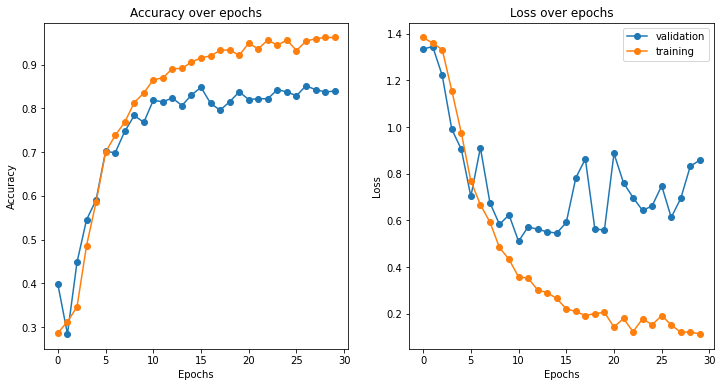

In [10]:
history = model5.history.history
fig, axs = plt.subplots(1, 2,figsize = (12,6))

axs[0].plot(history.get('val_accuracy'), label = 'validation', marker = 'o')
axs[0].plot(history.get('accuracy'), label = 'training', marker = 'o')
axs[0].set_title('Accuracy over epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epochs')
axs[1].plot(history.get('val_loss'), label = 'validation', marker = 'o')
axs[1].plot(history.get('loss'), label = 'training', marker = 'o')
axs[1].set_title('Loss over epochs')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epochs')

plt.legend()
mean_lasts = np.mean(history.get('val_accuracy')[-5:])
print(mean_lasts)

- High overfit, acceptable accuracy but does not compete with previous NN.